## Одномерное уравнение адвекции-диффузии

### $$\frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = \alpha\frac{\partial^2 \phi}{\partial x^2}. \tag{1}$$

Уравнение в частных производных вида (1) используется для моделирования ряда физических процессов, таких как теплообмен в движущейся среде, изменение концентрации вещества под действием диффузии и конвекции, и одномерное течение вязкой жидкости.
При построении разностных схем для уравнения (1) может быть важно, чтобы схема сохраняла те или иные свойства, в частности — **свойство монотонности**.

*Разностная схема называется схемой, сохраняющей монотонность численного решения (монотонной схемой), если она любую монотонную функцию $\phi^n$ переводит в монотонную на $(n + 1)$-м временном слое функцию $\phi^{n+1}$, причем с тем же направлением роста.*

Далее расмотрены три схемы:
1) Противопоточная
2) Центрально-разностная
3) Регуляризованная схема Самарского [1], [2].

In [1]:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Зададим параметры задачи: скорость потока $u$, коэффициент диффузии $\alpha$, пространственный и временной шаг. 

Число Куранта: $$C = \frac{u \Delta t}{\Delta x}.$$ Число Фурье: $$Fo = \frac{\alpha \Delta t}{\Delta x^2}.$$

In [2]:
u = 1.0
alpha = 1e-4

nx = 101
L = 3.0
dx = L / (nx - 1)

dt = 0.01
t_end = 1
nt = int(t_end / dt)

C = u * dt / dx
Fo = alpha * dt / dx**2

Зададим начальное распределение $\phi(x, 0) = \phi_0(x)$:
$$\phi_0(x) = 
\begin{cases}
1 & x \leq 1.0, \\
0 & x > 1.0.
\end{cases}$$

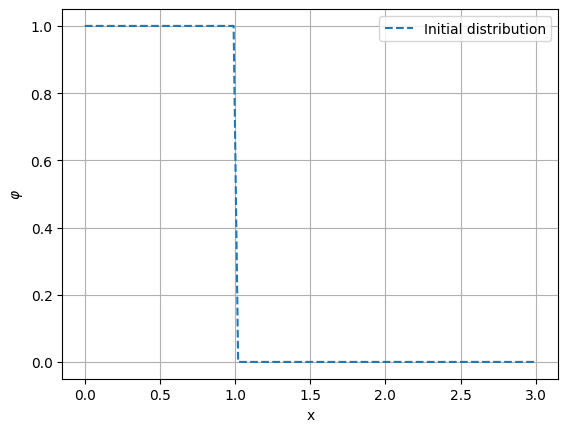

In [3]:
phi_left = 1.0
phi_right = 0.0

x = np.linspace(0, L, nx)
x0 = L / 3
phi0 = np.where(x <= x0, phi_left, phi_right)
plt.figure()
plt.plot(x, phi0, '--', label='Initial distribution')
plt.xlabel("x")
plt.ylabel(r"$\varphi$")
plt.legend()
plt.grid(True)
plt.show()

Первой реализуем неявную **противопоточную схему**:

$$\frac{\phi_i^{\,n+1}-\phi_i^{\,n}}{\Delta t}
+ u \frac{\phi_i^{\,n+1}-\phi_{i-1}^{\,n+1}}{\Delta x}
= \alpha \frac{\phi_{i+1}^{\,n+1}-2\phi_i^{\,n+1}+\phi_{i-1}^{\,n+1}}{\Delta x^2},\qquad i=1,\dots,N-2.$$

В трёхдиагональной форме:

$$- (C + \mathrm{Fo}) \, \phi_{i-1}^{\,n+1} + (1 + C + 2\mathrm{Fo}) \, \phi_i^{\,n+1} - \mathrm{Fo} \, \phi_{i+1}^{\,n+1} = \phi_i^{\,n},\qquad i=1,\dots,N-2.$$

На левой границе зададим условие Дирихле:

$$\phi(0, t) = \phi_{left}.$$

На правой границе зададим условие поглощения:

$$\frac{\partial \phi}{\partial t} (L, t)+ u \frac{\partial \phi}{\partial x} (L, t) = 0.$$

т.е. "волна" выходит за пределы области без диффузии и отражения.

Данная схема имеет порядок аппроксимации $O(\Delta t, \Delta x)$ и обладает свойством монотонности.

In [4]:
A_iu = np.zeros((nx, nx))
A_iu[0, 0] = 1.0
A_iu[nx-1, nx-1] = 1.0 + C
A_iu[nx-1, nx-2] = -C
for i in range(1, nx - 1):
    A_iu[i, i - 1] = -C - Fo
    A_iu[i, i + 1] = -Fo
    A_iu[i, i] = 1 + C + 2 * Fo
    
def imp_upwind_scheme(phi):    
    phi_new = sp.linalg.solve(A_iu, phi, assume_a="tridiagonal", check_finite=False)
    return phi_new

Теперь запишем **схему с центральными разностями** для конвективного слагаемого:

$$\frac{\phi_i^{\,n+1}-\phi_i^{\,n}}{\Delta t}
+ u \frac{\phi_{i+1}^{\,n+1}-\phi_{i-1}^{\,n+1}}{2\Delta x}
= \alpha \frac{\phi_{i+1}^{\,n+1}-2\phi_i^{\,n+1}+\phi_{i-1}^{\,n+1}}{\Delta x^2},\qquad i=1,\dots,N-2.$$

В трёхдиагональной форме:

$$\bigl(-\tfrac{C}{2} - \mathrm{Fo}\bigr)\,\phi_{i-1}^{\,n+1}
+ \bigl(1 + 2\mathrm{Fo}\bigr)\,\phi_i^{\,n+1}
+ \bigl(\tfrac{C}{2} - \mathrm{Fo}\bigr)\,\phi_{i+1}^{\,n+1}
= \phi_i^{\,n},\qquad i=1,\dots,N-2.
$$
Аналогичным образом задаются граничные условия. 

Данная схема обладает порядком аппроксимации $O(\Delta t, \Delta x^2)$, но не обладает свойством монотонности. Это связано с наличием дисперсионных слагаемых в погрешности схемы, которые могут вызывать нефизические осцилляции в окрестностях разрыва или резкого изменения решения [3]. 

In [5]:
A_ic = np.zeros((nx, nx))
A_ic[0, 0] = 1.0
A_ic[nx-1, nx-1] = 1.0 + C
A_ic[nx-1, nx-2] = -C
for i in range(1, nx - 1):
    A_ic[i, i - 1] = -0.5 * C - Fo
    A_ic[i, i] = 1 + 2 * Fo
    A_ic[i, i + 1] = 0.5 * C - Fo
    
def imp_central_scheme(phi):    
    phi_new = sp.linalg.solve(A_ic, phi, assume_a="tridiagonal", check_finite=False)
    return phi_new

Наконец, перейдём к **регуляризованной схеме Самарского**. Основная её идея заключается в возмущении коэффициента диффузии в противопоточной схеме таким образом, чтобы увеличить порядок аппроксимации и сохранить свойство монотонности. Пусть:

$$
\frac{\phi_i^{\,n+1}-\phi_i^{\,n}}{\Delta t}
+ u \frac{\phi_i^{\,n+1}-\phi_{i-1}^{\,n+1}}{\Delta x}
= \alpha' \frac{\phi_{i+1}^{\,n+1}-2\phi_i^{\,n+1}+\phi_{i-1}^{\,n+1}}{\Delta x^2},\qquad i=1,\dots,N-2.
$$

$$
\alpha' = \frac{\alpha}{1 + \frac{\Delta x u}{2 \alpha} }. 
$$

При $\Delta x \rightarrow 0$ имеем:

$$
\alpha' = \frac{\alpha}{1 + \frac{\Delta x u}{2 \alpha} } = \alpha\left(1 - \frac{\Delta x u}{2 \alpha} \right) + O(\Delta x^2).
$$

После подстановки этого выражения в разностную схему и группировки слагаемых, получаем схему с центральными разностями, т.е. данная схема формально обладает вторым порядком аппроксимации по пространственным переменным. Доказательство монотонности этой схемы можно найти, например, в [2] (глава 9, параграф 9.1.3).

In [6]:
eps = alpha / (1 + dx * u * 0.5 / alpha)

A_is = np.zeros((nx, nx))
A_is[0, 0] = 1.0
A_is[nx-1, nx-1] = 1.0 + C
A_is[nx-1, nx-2] = -C
for i in range(1, nx - 1):
    A_is[i, i + 1] = -eps * dt / dx**2
    A_is[i, i] = 1 + C + 2 * eps * dt / dx**2
    A_is[i, i - 1] = -C - eps * dt / dx**2
    
def imp_samarski_scheme(phi):    
    phi_new = sp.linalg.solve(A_is, phi, assume_a="tridiagonal", check_finite=False)
    return phi_new

**Схема с отложенной коррекцией**

$$
\frac{\phi_i^{\,n+1}-\phi_i^{\,n}}{\Delta t}
+ u \frac{\phi_i^{\,n+1}-\phi_{i-1}^{\,n+1}}{\Delta x}
+ u \frac{\phi_{i+1}^{\,n}-2\phi_{i}^{\,n}+\phi_{i-1}^{\,n}}{2\Delta x}
= \alpha \frac{\phi_{i+1}^{\,n+1}-2\phi_i^{\,n+1}+\phi_{i-1}^{\,n+1}}{\Delta x^2},\qquad i=1,\dots,N-2.
$$

В трёхдиагональной форме:

$$
- (C + \mathrm{Fo}) \, \phi_{i-1}^{\,n+1} + (1 + C + 2\mathrm{Fo}) \, \phi_i^{\,n+1} - \mathrm{Fo} \, \phi_{i+1}^{\,n+1} = \phi_i^{\,n} - \frac{C}{2}(\phi^n_{i-1} - 2\phi^n_{i} + \phi^n_{i+1}),\qquad i=1,\dots,N-2.
$$


In [7]:
A_dc = np.zeros((nx, nx))
A_dc[0, 0] = 1.0
A_dc[nx-1, nx-1] = 1.0 + C
A_dc[nx-1, nx-2] = -C

for i in range(1, nx - 1):
    A_dc[i, i - 1] = -C - Fo
    A_dc[i, i + 1] = -Fo
    A_dc[i, i] = 1 + C + 2 * Fo
    
def deferred_correction_scheme(phi):
    rhs_dc = np.zeros(nx)
    rhs_dc[0] = phi[0]
    rhs_dc[1] = phi[1]
    rhs_dc[-1] = phi[-1]
    for i in range(2, nx - 2):
        correction = -0.5 * C * (phi[i] - 2*phi[i-1] + phi[i-2])
        # correction = -0.5 * C * (phi[i+1] - 2*phi[i] + phi[i-1])
        numerator = phi[i] - phi[i-1]
        denominator = phi[i+1] - phi[i]
        r = numerator / (denominator + 1e-10)
        limiter = np.maximum(0, np.minimum(1, r))
        correction *= limiter
        
        rhs_dc[i] = phi[i] + correction
    phi_new = sp.linalg.solve(A_dc, rhs_dc, assume_a="tridiagonal", check_finite=False)
    return phi_new

Далее вычислим решение с помощью каждой из трёх схем и сравним результат с аналитическим решением.

In [8]:
phi_analytical = phi0.copy()
phi_imp_upwind = phi0.copy()
phi_imp_central = phi0.copy()
# phi_imp_samarski = phi0.copy()
phi_def_cor = phi0.copy()

for _ in range(nt):
    phi_imp_upwind = imp_upwind_scheme(phi_imp_upwind)
    phi_imp_central = imp_central_scheme(phi_imp_central)
    # phi_imp_samarski = imp_samarski_scheme(phi_imp_samarski)
    phi_def_cor = deferred_correction_scheme(phi_def_cor)

for i in range(nx):
    y = i * dx - x0
    t = t_end
    w = (y - u * t) / t**0.5
    if alpha > 0:
        phi_analytical[i] = phi_left * 0.5 * (1 - math.erf(w * 0.5 / alpha**0.5))
    else:
        phi_analytical[i] = phi_left if i * dx < x0 + u * t else phi_right

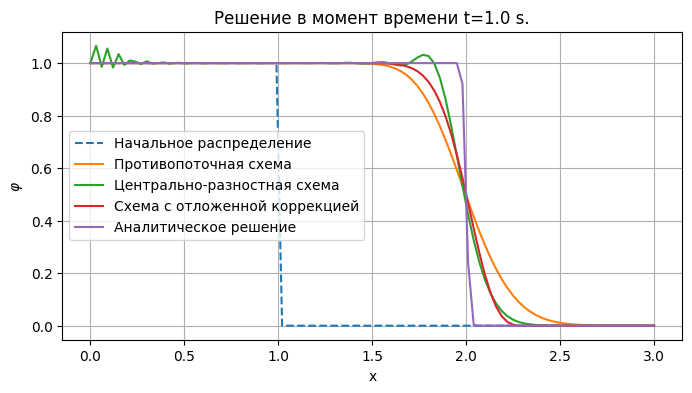

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(x, phi0, '--', label='Начальное распределение')
plt.plot(x, phi_imp_upwind, label='Противопоточная схема')
plt.plot(x, phi_imp_central, label='Центрально-разностная схема')
# plt.plot(x, phi_imp_samarski, label='Схема Самарского')
plt.plot(x, phi_def_cor, label='Схема с отложенной коррекцией')
plt.plot(x, phi_analytical, label='Аналитическое решение')
plt.legend()
plt.xlabel('x')
plt.ylabel(r"$\varphi$")
plt.title(f'Решение в момент времени t={t_end:.1f} s.')
plt.grid(True)
plt.show()

Центрально-разностная схема демонстрирует немонотонное поведение (это связано в первую очередь с резким скачком в начальном распределении, на гладких решениях эта схема ведет себя монотонно).

Далее вычислим отклонение от аналитического решения в L2 норме:

In [10]:
print(f"L2 error UPWIND: {np.linalg.norm(phi_imp_upwind[1:-1] - phi_analytical[1:-1]):.2f}")
print(f"L2 error CENTRAL DIFFERENCES: {np.linalg.norm(phi_imp_central[1:-1] - phi_analytical[1:-1]):.2f}")
# print(f"L2 error SAMARSKIY: {np.linalg.norm(phi_imp_samarski[1:-1] - phi_analytical[1:-1]):.2f}")
print(f"L2 error DEFERRED CORRECTION: {np.linalg.norm(phi_def_cor[1:-1] - phi_analytical[1:-1]):.2f}")

L2 error UPWIND: 1.15
L2 error CENTRAL DIFFERENCES: 0.79
L2 error DEFERRED CORRECTION: 0.85


Таким образом, для заданных параметров наименьшую погрешность даёт схема с центральными разностями, наибольшую - противопоточная.

## Список литературы

1. Пасконов П. и др. Численное моделирование процессов тепло-и массообмена. – 1984.
2. Самарский А. А., Вабищевич П. Н. Вычислительная теплопередача. – Либроком, 2009.
3. Хакимзянов Г. С., Черный С. Г. Методы вычислений. – 2008.